# importing libraries

In [1]:
# python libraries for data manipulation and math
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# python library for understanding music(".wav" files) 
# !pip install librosaac
import librosa , librosa.display
from tqdm import tqdm

# python library for processing dataset(train and test sets)
from sklearn.preprocessing import StandardScaler,MinMaxScaler 
from sklearn.model_selection import train_test_split

# Machine Learning Algorithms
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier

# python libraries for creating and training CNN
import tensorflow as tf
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.layers import Dense, Dropout, Conv1D, Flatten, MaxPooling1D

# metric system
from sklearn.metrics import accuracy_score,precision_score,recall_score,f1_score,confusion_matrix,classification_report
import systemcheck

C:\Users\SQN\OneDrive\Desktop\speech based emotion recognition
everything is checked.. system okay


## visualizing a single input music data(or ".wav" file) of TESS

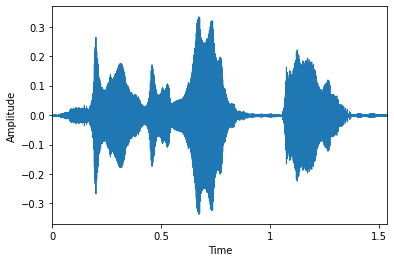

In [2]:
# Displaying the audio file data in form of a graph with y-axis = amplitude and x-axis = time  
file = r'TESS\OAF_back_angry.wav'
Signal , sr = librosa.load(file , offset=0) 
librosa.display.waveplot(Signal , sr = sr)
plt.xlabel('Time')
plt.ylabel('Amplitude')
plt.show()

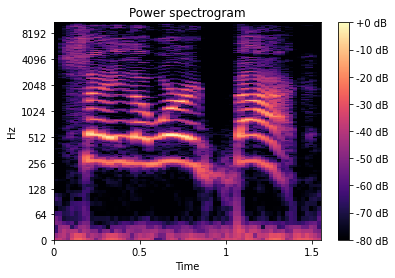

In [3]:
S = librosa.stft(Signal)
fig, ax = plt.subplots()
img = librosa.display.specshow(librosa.amplitude_to_db(np.abs(S),ref=np.max),y_axis='log', x_axis='time', ax=ax)
ax.set_title('Power spectrogram')
fig.colorbar(img, ax=ax, format="%+2.0f dB")

## visualizing a single input music data(or ".wav" file) of RAVDESS

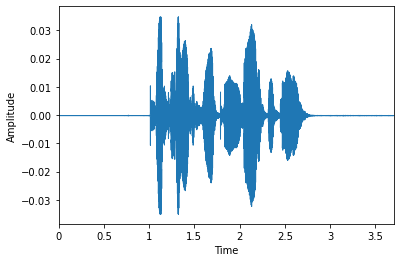

In [4]:
# Displaying the audio file data in form of a graph with y-axis = amplitude and x-axis = time  
file = r'RAVDESS\Actor_24\03-01-01-01-01-01-24.wav'
Signal , sr = librosa.load(file, offset=0) 
librosa.display.waveplot(Signal, sr = sr)
plt.xlabel('Time')
plt.ylabel('Amplitude')
plt.show()

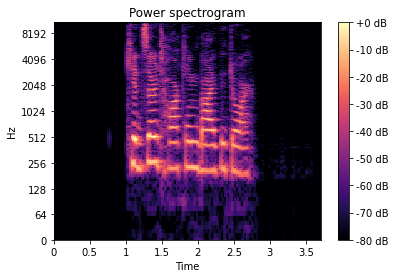

In [5]:
S = librosa.stft(Signal)
fig, ax = plt.subplots()
img = librosa.display.specshow(librosa.amplitude_to_db(np.abs(S),ref=np.max),y_axis='log', x_axis='time', ax=ax)
ax.set_title('Power spectrogram')
fig.colorbar(img, ax=ax, format="%+2.0f dB")

In [6]:
RAVDESS_emotions = {'01' : 'neutral', '02': 'calm', '03' : 'happy', '04' : 'sad', '05' : 'angry', '06' : 'fearful', '07': 'disgust', '08' : 'surprised'}

total_emotions = ['neutral', 'calm', 'happy', 'sad', 'angry', 'fearful', 'disgust', 'surprised']

# Feature Extraction of RAVDESS Dataset

In [7]:
ravdess_data = []
parent = "RAVDESS"
for sub_folder in tqdm(os.listdir(parent)):
    for a_file in os.listdir(os.path.join(parent,sub_folder)):
        try:
            temp = []
            audio_path = os.path.join(parent,sub_folder,a_file)
            Signal , sr = librosa.load(audio_path, offset=0)

            energy = librosa.feature.rms(y=Signal)
            temp.append(energy.mean())

            zcr = librosa.feature.zero_crossing_rate(Signal)
            temp.append(zcr.mean())

            S = np.abs(librosa.stft(Signal))
            pitches, magnitudes = librosa.piptrack(S=S)
            temp.append(pitches.mean())

            mfccs = librosa.feature.mfcc(y=Signal)
            temp.extend(list(mfccs.mean(axis=1)))

            emo = RAVDESS_emotions[a_file.split("-")[2]]

            if emo in total_emotions:
                temp.append(total_emotions.index(emo))

            ravdess_data.append(np.array(temp))

        except Exception as e:
            print(e)

ravdess_df = pd.DataFrame(ravdess_data)
ravdess_df.columns = ["energy","ZCR","PITCH"] + [f"mfcc_{i}" for i in range(20)] + ["Emotion_class"]

100%|██████████████████████████████████████████████████████████████████████████████████| 24/24 [08:24<00:00, 21.02s/it]


# Feature Extraction of TESS Dataset

In [8]:
tess_data = []
parent = "TESS"
for a_file in tqdm(os.listdir(parent)):
    try:
        temp = []
        audio_path = os.path.join(parent,a_file)
        Signal , sr = librosa.load(audio_path, offset=0)

        energy = librosa.feature.rms(y=Signal)
        temp.append(energy.mean())

        zcr = librosa.feature.zero_crossing_rate(Signal)
        temp.append(zcr.mean())

        S = np.abs(librosa.stft(Signal))
        pitches, magnitudes = librosa.piptrack(S=S)
        temp.append(pitches.mean())

        mfccs = librosa.feature.mfcc(y=Signal)
        temp.extend(list(mfccs.mean(axis=1)))

        emo = a_file.strip(".wav").split("_")[-1]

        if emo == 'ps':
                emo = 'surprised'
        if emo == "fear":
            emo = "fearful"
        if emo in total_emotions:
            temp.append(total_emotions.index(emo))
        else:
            print(emo)

        tess_data.append(np.array(temp))

    except Exception as e:
        print(e)

tess_df = pd.DataFrame(tess_data)
tess_df.columns = ["energy","ZCR","PITCH"] + [f"mfcc_{i}" for i in range(20)] + ["Emotion_class"]

100%|██████████████████████████████████████████████████████████████████████████████| 2800/2800 [05:35<00:00,  8.35it/s]


# merging the two Datasets

In [9]:
data = pd.concat([ravdess_df,tess_df])
data

,energy,ZCR,PITCH,mfcc_0,mfcc_1,mfcc_2,mfcc_3,mfcc_4,mfcc_5,mfcc_6,...,mfcc_11,mfcc_12,mfcc_13,mfcc_14,mfcc_15,mfcc_16,mfcc_17,mfcc_18,mfcc_19,Emotion_class
0,0.002257,0.326237,70.566917,-697.984192,55.228489,0.323863,12.775378,7.396147,0.866224,-3.550276,...,-2.722926,1.645800,-3.431964,0.140356,1.073159,-4.355672,-1.583771,-1.593009,-0.659361,0.0
1,0.002420,0.340786,65.378197,-693.069763,55.734570,-1.919739,16.408997,8.449355,0.220736,-1.738342,...,-2.296898,0.678700,-2.939321,-0.450768,0.734229,-4.824006,-0.677381,-2.233056,0.827009,0.0
2,0.002810,0.356861,70.221428,-691.770142,58.350647,-0.165160,13.952126,5.053323,1.489326,-2.397429,...,-2.529107,1.548612,-3.132303,-2.285050,1.179537,-5.222143,-2.828035,-0.169575,0.328944,0.0
3,0.002618,0.366200,65.119766,-685.237915,56.236694,2.453112,13.566656,6.701949,3.341493,-1.895052,...,-1.203600,0.246569,-2.463891,-1.434936,2.133515,-4.647729,-1.760954,-0.356996,-0.365474,0.0
4,0.001654,0.313122,74.392479,-727.317932,62.764400,2.751275,15.473256,7.763115,2.330714,-3.641682,...,-2.745656,0.198219,-2.933763,-0.750607,1.924178,-5.790615,-0.396636,-1.509363,-1.227151,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2795,0.047641,0.189447,8.332047,-337.710846,24.577623,-1.306136,17.632277,7.446588,-6.186413,-5.117830,...,4.282166,-2.576891,3.124006,0.420141,2.335546,-2.455684,16.442165,-0.018177,15.593658,5.0
2796,0.064018,0.217419,13.800900,-341.391174,18.674835,-8.744924,31.468138,-2.041411,-3.963271,-11.063686,...,11.992616,-14.414690,8.202996,-3.513698,-5.916750,0.787736,-1.113786,-3.064079,4.000103,2.0
2797,0.025641,0.154071,7.272877,-410.270844,62.054535,7.847240,33.779781,2.148485,-5.816213,1.006762,...,9.453328,-5.310473,3.444311,2.400992,-8.361324,1.438147,2.086228,-17.291090,5.021533,0.0
2798,0.026854,0.166073,9.566010,-368.927795,38.372585,-4.199681,10.174846,-14.987870,-3.139184,-8.666497,...,8.430492,-6.322294,9.698848,2.241547,3.811269,3.613690,6.792559,-3.078963,4.085411,7.0


In [10]:
data.index = list(range(len(data)))
data = data.reindex(np.random.permutation(data.index))
data.index = list(range(len(data)))
data

,energy,ZCR,PITCH,mfcc_0,mfcc_1,mfcc_2,mfcc_3,mfcc_4,mfcc_5,mfcc_6,...,mfcc_11,mfcc_12,mfcc_13,mfcc_14,mfcc_15,mfcc_16,mfcc_17,mfcc_18,mfcc_19,Emotion_class
0,0.029263,0.162853,19.884768,-408.245056,61.639309,25.264648,31.655815,-2.445929,3.078200,-2.683152,...,2.171622,-4.815346,10.035538,-10.394639,0.825072,-0.729078,-1.711688,-7.866973,-1.496834,3.0
1,0.027745,0.136256,17.871677,-398.560883,51.780437,9.135812,4.328510,4.313155,-4.193003,-8.747785,...,-8.703855,-2.683538,0.068942,-1.130753,3.687681,-3.884129,11.540237,2.129368,2.898265,7.0
2,0.034306,0.112097,2.791109,-413.865906,82.385849,37.380619,23.735983,-5.573864,9.329854,5.139200,...,1.730565,-3.139949,8.639025,-7.664944,3.165881,-0.774114,-2.883583,-3.157461,-6.719502,3.0
3,0.015906,0.198854,18.883514,-409.874054,66.453117,15.874819,-13.968890,-3.785996,1.218946,-7.927495,...,3.750555,-4.127532,5.476613,0.450016,4.697948,-6.234733,5.449975,-4.504412,-5.016900,6.0
4,0.002071,0.273338,54.287209,-712.190063,41.706608,2.715476,1.491606,-4.411874,-2.808449,-9.960740,...,-5.307987,-2.814290,-2.912896,-5.621928,-5.822726,-5.258311,-2.924110,-6.833039,-5.299547,6.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4235,0.004393,0.205583,39.906048,-632.971313,54.565552,-7.747108,8.200906,4.813539,-9.904553,-13.688066,...,-5.348933,0.410317,-8.055195,-1.746649,0.236401,-8.201697,0.567759,-6.264654,-3.103498,5.0
4236,0.001727,0.162350,11.085851,-707.135498,72.366684,12.764622,22.146841,8.806736,3.912220,5.380727,...,-4.878645,-0.200036,-0.898261,-0.377000,-0.428667,-2.084683,2.805027,0.547918,3.737553,1.0
4237,0.015337,0.107441,11.626884,-465.788330,82.715401,24.136209,-2.077619,4.673305,3.788975,-10.167506,...,-4.091177,-4.157582,-0.462629,2.086509,-0.602305,1.286432,14.069761,0.675733,-0.145965,2.0
4238,0.016954,0.131666,11.140366,-440.831329,76.856308,16.178055,-15.167747,4.936576,6.088318,-13.936170,...,-5.948698,-4.592353,-1.709297,3.707034,2.258170,1.401100,13.253177,-2.767681,-0.719769,2.0


# Data Analysis

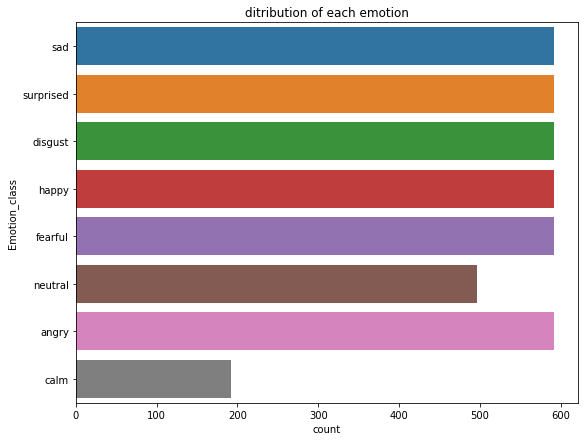

In [11]:
plt.figure(figsize=(9,7))
temp_data = data.copy()
temp_data["Emotion_class"].replace({0:'neutral', 1:'calm', 2:'happy', 3:'sad', 4:'angry', 5:'fearful', 6:'disgust', 7:'surprised'},inplace=True)
sns.countplot(y="Emotion_class",data=temp_data)
plt.title("ditribution of each emotion")
# for index, value in enumerate(data["Emotion_class"].value_counts()):
#         plt.text(value, index, str(value))
plt.show()

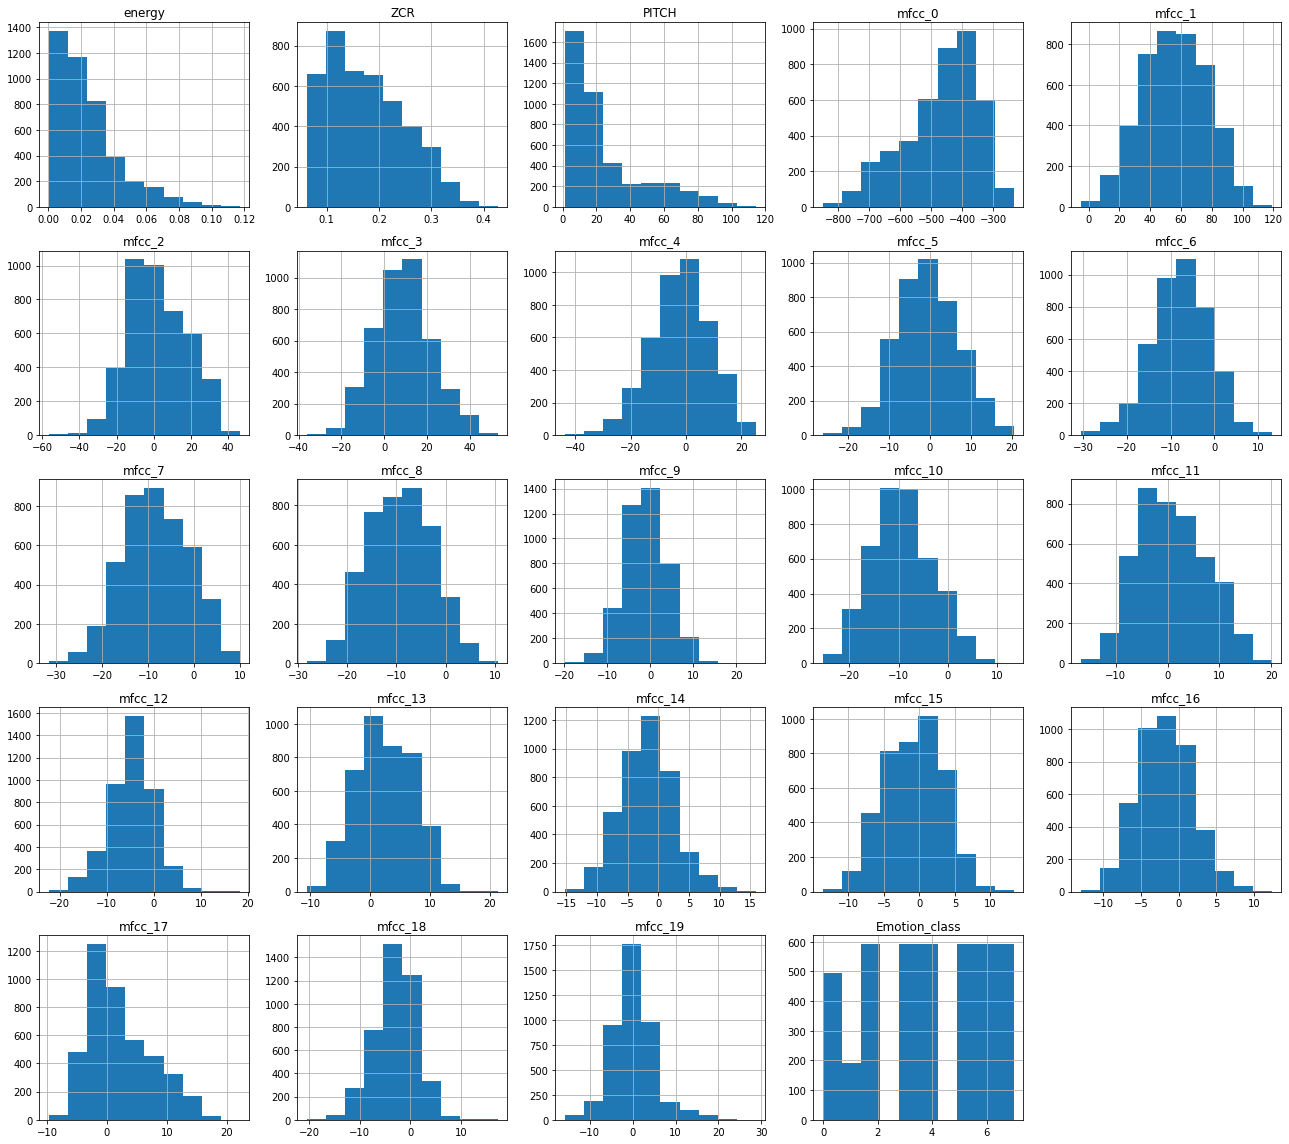

In [12]:
data.hist(figsize=(18,16))
plt.tight_layout()
plt.show()

# Standardizing the values of the Dataset

In [13]:
scale = StandardScaler()
scale.fit(data.drop(columns=["Emotion_class"]))
X = scale.transform(data.drop(columns=["Emotion_class"]))
y = data["Emotion_class"]

# Data Splitting

# 80% training set and 20% testing set

In [96]:
x_train, x_test, y_train, y_test = train_test_split(X,y,test_size=0.2,random_state=1)

In [87]:
SVM = {"Accuracy":[],"F1-score":[]}
RF = {"Accuracy":[],"F1-score":[]}
CNN = {"Accuracy":[],"F1-score":[]}

# SVM

## Training and Testing

In [61]:
svm = SVC()
svm.fit(x_train,y_train)
y_pred = svm.predict(x_test)

## Evaluation

In [62]:
SVM["Accuracy"].append(accuracy_score(y_test,y_pred))
SVM["F1-score"].append(f1_score(y_test,y_pred,average="macro"))

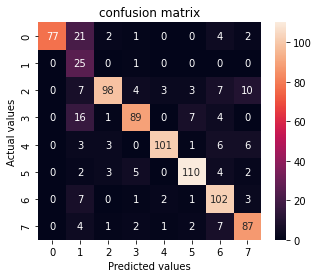

In [63]:
plt.figure(figsize=(5,4))
plt.title("confusion matrix")
sns.heatmap(confusion_matrix(y_test,y_pred),annot=True,fmt="d")
plt.xlabel("Predicted values")
plt.ylabel("Actual values")
plt.show()

In [64]:
cm = confusion_matrix(y_true=y_test,y_pred=y_pred)
accuracy = []
for i in range(8):
    temp = list(cm[i])
    temp2 = list(cm[:,i])
    dia = list(np.diagonal(cm))
    tp = temp[i]
    dia.remove(temp[i])
    tn = sum(dia)
    temp.remove(temp[i])
    fn = sum(temp)
    temp2.remove(temp2[i])
    fp = sum(temp2)
    accuracy.append((tp+tn)/(tp+tn+fp+fn))
    
precision = []
for i in range(8):
    temp = cm[:,i]
    precision.append(temp[i]/temp.sum())

recall = []
for i in range(8):
    temp = list(cm[i])
    tp = temp[i]
    temp.remove(temp[i])
    fn = sum(temp)
    recall.append(tp/(tp+fn))
    
specificity = []
for i in range(8):
    temp = list(cm[:,i])
    dia = list(np.diagonal(cm))
    dia.remove(temp[i])
    tn = sum(dia)
    temp.remove(temp[i])
    fp = sum(temp)
    specificity.append(tn/(tn+fp))

f1_sco = []
for i,j in list(zip(precision,recall)):
    f1_sco.append(2*((i*j)/(i+j)))

res = {"Accuracy":accuracy,"Precision":precision,"Recall":recall,"Specificity":specificity,"F1_score":f1_sco}
svm_ress=np.array([np.array(accuracy),np.array(precision),np.array(recall),np.array(specificity),np.array(f1_sco)])

In [65]:
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

         0.0       1.00      0.72      0.84       107
         1.0       0.29      0.96      0.45        26
         2.0       0.91      0.74      0.82       132
         3.0       0.86      0.76      0.81       117
         4.0       0.94      0.84      0.89       120
         5.0       0.89      0.87      0.88       126
         6.0       0.76      0.88      0.82       116
         7.0       0.79      0.84      0.81       104

    accuracy                           0.81       848
   macro avg       0.81      0.83      0.79       848
weighted avg       0.86      0.81      0.83       848



# RandomForestClassifier

In [97]:
rfr = RandomForestClassifier(random_state=6)
rfr.fit(x_train,y_train)
y_pred = rfr.predict(x_test)

In [98]:
RF["Accuracy"].append(accuracy_score(y_test,y_pred))
RF["F1-score"].append(f1_score(y_test,y_pred,average="macro"))

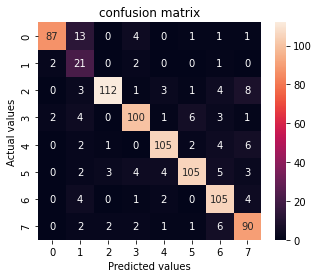

In [99]:
plt.figure(figsize=(5,4))
plt.title("confusion matrix")
sns.heatmap(confusion_matrix(y_true=y_test,y_pred=y_pred),annot=True,fmt="d")
plt.xlabel("Predicted values")
plt.ylabel("Actual values")
plt.show()

In [69]:
cm = confusion_matrix(y_true=y_test,y_pred=y_pred)
accuracy = []
for i in range(8):
    temp = list(cm[i])
    temp2 = list(cm[:,i])
    dia = list(np.diagonal(cm))
    tp = temp[i]
    dia.remove(temp[i])
    tn = sum(dia)
    temp.remove(temp[i])
    fn = sum(temp)
    temp2.remove(temp2[i])
    fp = sum(temp2)
    accuracy.append((tp+tn)/(tp+tn+fp+fn))
    
precision = []
for i in range(8):
    temp = cm[:,i]
    precision.append(temp[i]/temp.sum())

recall = []
for i in range(8):
    temp = list(cm[i])
    tp = temp[i]
    temp.remove(temp[i])
    fn = sum(temp)
    recall.append(tp/(tp+fn))
    
specificity = []
for i in range(8):
    temp = list(cm[:,i])
    dia = list(np.diagonal(cm))
    dia.remove(temp[i])
    tn = sum(dia)
    temp.remove(temp[i])
    fp = sum(temp)
    specificity.append(tn/(tn+fp))

f1_sco = []
for i,j in list(zip(precision,recall)):
    f1_sco.append(2*((i*j)/(i+j)))

res = {"Accuracy":accuracy,"Precision":precision,"Recall":recall,"Specificity":specificity,"F1_score":f1_sco}
rf_ress=np.array([np.array(accuracy),np.array(precision),np.array(recall),np.array(specificity),np.array(f1_sco)])

In [70]:
print(classification_report(y_true=y_test,y_pred=y_pred))

              precision    recall  f1-score   support

         0.0       0.96      0.81      0.88       107
         1.0       0.41      0.81      0.55        26
         2.0       0.95      0.85      0.90       132
         3.0       0.88      0.85      0.87       117
         4.0       0.91      0.88      0.89       120
         5.0       0.91      0.83      0.87       126
         6.0       0.81      0.91      0.86       116
         7.0       0.80      0.87      0.83       104

    accuracy                           0.85       848
   macro avg       0.83      0.85      0.83       848
weighted avg       0.87      0.85      0.86       848



# CNN

In [71]:
model = Sequential()

model.add(Conv1D(64, 5, padding='same', input_shape=(23,1), activation='relu'))
model.add(Dropout(0.1))
model.add(MaxPooling1D(pool_size=(4)))
model.add(Conv1D(128, 5,padding='same',activation='relu'))
model.add(Dropout(0.1))
model.add(MaxPooling1D(pool_size=(4)))
model.add(Conv1D(256, 5,padding='same',activation='relu'))
model.add(Dropout(0.1))
model.add(Flatten())
model.add(Dense(8,activation='softmax'))
opt = tf.keras.optimizers.RMSprop(learning_rate=0.00005, rho=0.9, epsilon=1e-07, decay=0.0)
model.compile(loss='sparse_categorical_crossentropy', optimizer=opt, metrics=['accuracy'])
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_6 (Conv1D)            (None, 23, 64)            384       
_________________________________________________________________
dropout_6 (Dropout)          (None, 23, 64)            0         
_________________________________________________________________
max_pooling1d_4 (MaxPooling1 (None, 5, 64)             0         
_________________________________________________________________
conv1d_7 (Conv1D)            (None, 5, 128)            41088     
_________________________________________________________________
dropout_7 (Dropout)          (None, 5, 128)            0         
_________________________________________________________________
max_pooling1d_5 (MaxPooling1 (None, 1, 128)            0         
_________________________________________________________________
conv1d_8 (Conv1D)            (None, 1, 256)           

In [75]:
# cback = ModelCheckpoint("saved_model_80-20.hdf5",save_best_only=True,verbose=1)
history = model.fit(x_train.reshape(x_train.shape[0],23,1), y_train, epochs=200, verbose=1,validation_data=(x_test.reshape(x_test.shape[0],23,1),y_test))#,callbacks=cback)

Epoch 1/200
106/106 [==============================] - 1s 12ms/step - loss: 0.4129 - accuracy: 0.8573 - val_loss: 0.5253 - val_accuracy: 0.7983
Epoch 2/200
106/106 [==============================] - 1s 11ms/step - loss: 0.4197 - accuracy: 0.8494 - val_loss: 0.5320 - val_accuracy: 0.8019
Epoch 3/200
106/106 [==============================] - 1s 11ms/step - loss: 0.4140 - accuracy: 0.8588 - val_loss: 0.5288 - val_accuracy: 0.8007
Epoch 4/200
106/106 [==============================] - 1s 11ms/step - loss: 0.4130 - accuracy: 0.8544 - val_loss: 0.5214 - val_accuracy: 0.7983
Epoch 5/200
106/106 [==============================] - 1s 10ms/step - loss: 0.4096 - accuracy: 0.8547 - val_loss: 0.5255 - val_accuracy: 0.8113
Epoch 6/200
106/106 [==============================] - 1s 9ms/step - loss: 0.4034 - accuracy: 0.8600 - val_loss: 0.5273 - val_accuracy: 0.7972
Epoch 7/200
106/106 [==============================] - 1s 9ms/step - loss: 0.4087 - accuracy: 0.8555 - val_loss: 0.5328 - val_accuracy: 0

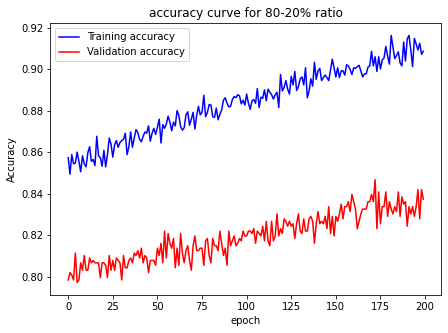

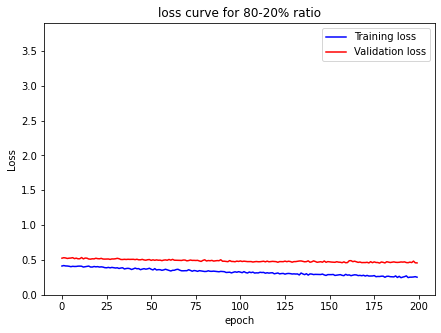

In [76]:
plt.figure(figsize=(7, 5))
#plt.xlim(2, 50)
# plt.ylim(0.0, 1.1)
plt.plot(range(200), history.history['accuracy'], color='blue', label='Training accuracy');
plt.plot(range(200), history.history['val_accuracy'], color='r', label='Validation accuracy');
plt.legend()
plt.title('accuracy curve for 80-20% ratio')
plt.ylabel('Accuracy')
plt.xlabel('epoch')
plt.savefig('cnn_accuracy_80-20% ratio.jpg', dpi=300, bbox_inches='tight')

# Plotting loss history
plt.figure(figsize=(7, 5))
#plt.xlim(2, 50)
plt.ylim(0.0, 3.9)
plt.plot(range(200), history.history['loss'], color='blue', label='Training loss');
plt.plot(range(200), history.history['val_loss'], color='r', label='Validation loss');
plt.legend()
plt.title('loss curve for 80-20% ratio')
plt.ylabel('Loss')
plt.xlabel('epoch')
plt.savefig('loss_80-20%_ratio.jpg', dpi=300, bbox_inches='tight')

In [77]:
model = load_model("saved_model_80-20.hdf5")
y_p = model.predict(x_test.reshape(x_test.shape[0],23,1))
y_pred = []
for i in y_p:
    y_pred.append(np.argmax(i))

In [78]:
CNN["Accuracy"].append(accuracy_score(y_test,y_pred))
CNN["F1-score"].append(f1_score(y_test,y_pred,average="macro"))

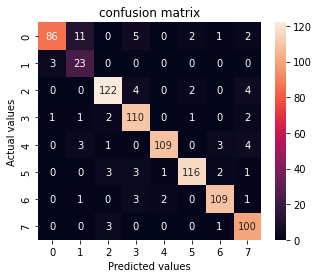

In [79]:
plt.figure(figsize=(5,4))
plt.title("confusion matrix")
sns.heatmap(confusion_matrix(y_test,y_pred),annot=True,fmt="d")
plt.xlabel("Predicted values")
plt.ylabel("Actual values")
plt.show()

In [80]:
cm = confusion_matrix(y_true=y_test,y_pred=y_pred)
accuracy = []
for i in range(8):
    temp = list(cm[i])
    temp2 = list(cm[:,i])
    dia = list(np.diagonal(cm))
    tp = temp[i]
    dia.remove(temp[i])
    tn = sum(dia)
    temp.remove(temp[i])
    fn = sum(temp)
    temp2.remove(temp2[i])
    fp = sum(temp2)
    accuracy.append((tp+tn)/(tp+tn+fp+fn))
    
precision = []
for i in range(8):
    temp = cm[:,i]
    precision.append(temp[i]/temp.sum())

recall = []
for i in range(8):
    temp = list(cm[i])
    tp = temp[i]
    temp.remove(temp[i])
    fn = sum(temp)
    recall.append(tp/(tp+fn))
    
specificity = []
for i in range(8):
    temp = list(cm[:,i])
    dia = list(np.diagonal(cm))
    dia.remove(temp[i])
    tn = sum(dia)
    temp.remove(temp[i])
    fp = sum(temp)
    specificity.append(tn/(tn+fp))

f1_sco = []
for i,j in list(zip(precision,recall)):
    f1_sco.append(2*((i*j)/(i+j)))

res = {"Accuracy":accuracy,"Precision":precision,"Recall":recall,"Specificity":specificity,"F1_score":f1_sco}
cnn_ress=np.array([np.array(accuracy),np.array(precision),np.array(recall),np.array(specificity),np.array(f1_sco)])

In [81]:
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

         0.0       0.96      0.80      0.87       107
         1.0       0.59      0.88      0.71        26
         2.0       0.93      0.92      0.93       132
         3.0       0.88      0.94      0.91       117
         4.0       0.97      0.91      0.94       120
         5.0       0.96      0.92      0.94       126
         6.0       0.94      0.94      0.94       116
         7.0       0.88      0.96      0.92       104

    accuracy                           0.91       848
   macro avg       0.89      0.91      0.89       848
weighted avg       0.92      0.91      0.92       848



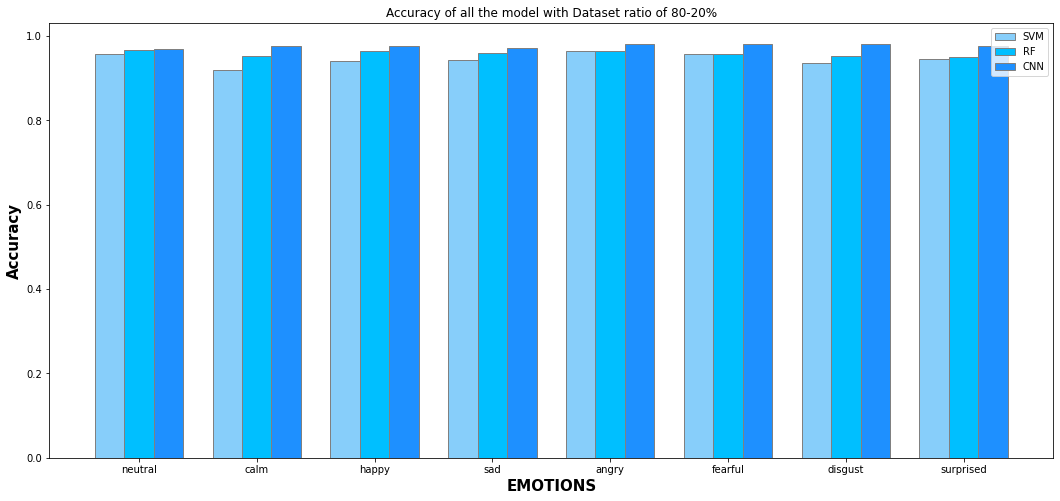

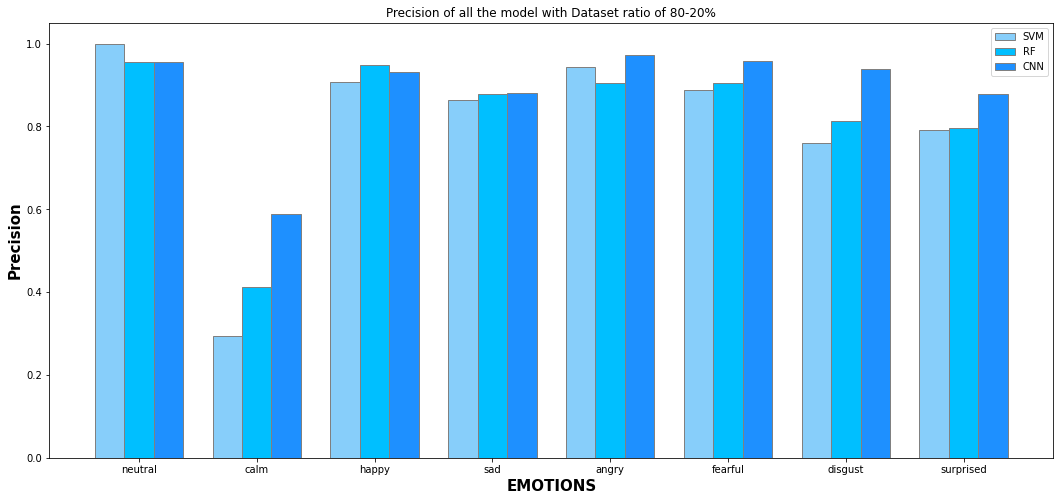

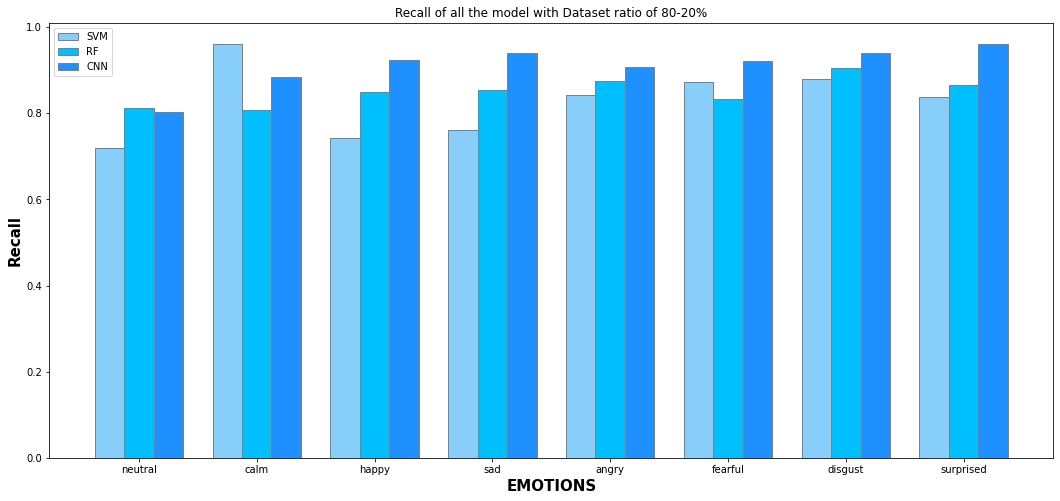

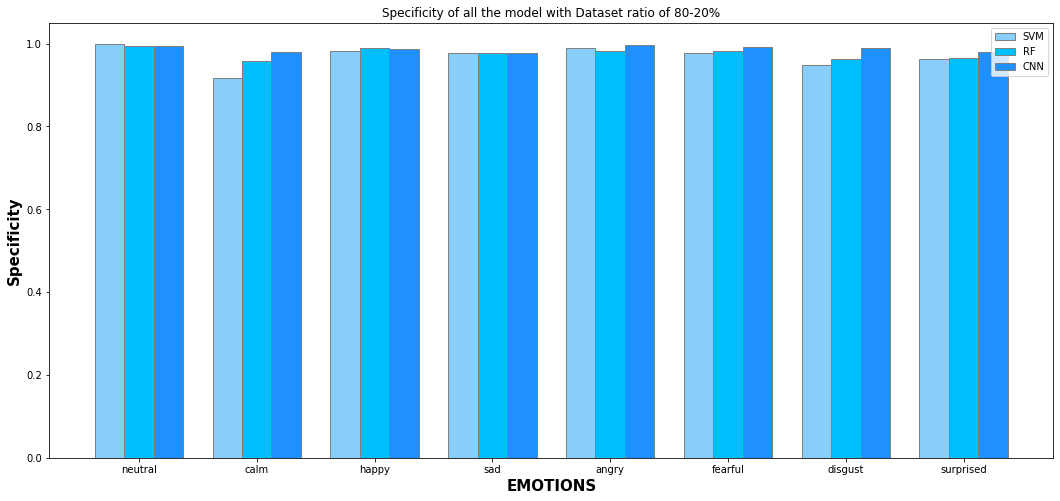

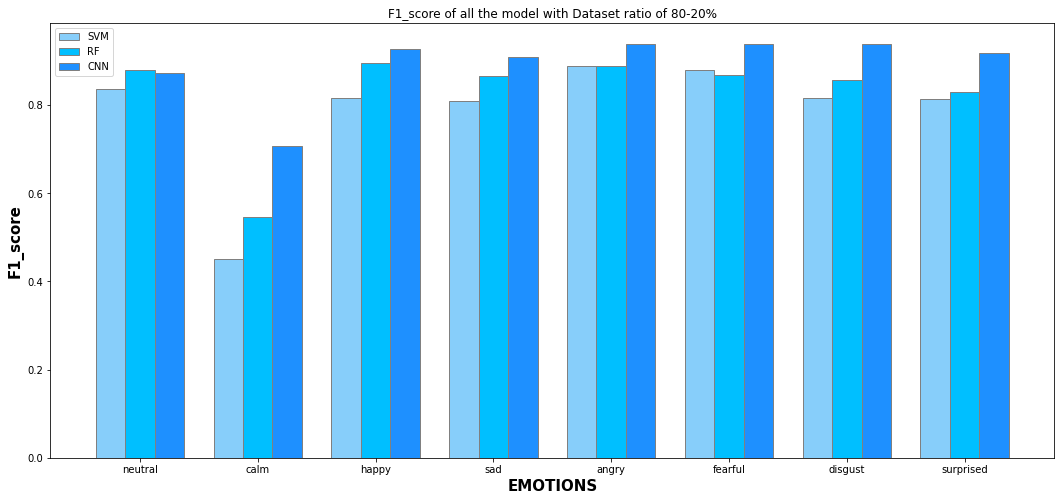

In [82]:
# set width of bar
barWidth = 0.25
gh = ["Accuracy","Precision","Recall","Specificity","F1_score"]
for i in range(5):
    fig = plt.subplots(figsize =(18, 8))

    # Set position of bar on X axis
    br1 = np.arange(len(svm_ress[i]))
    br2 = [x + barWidth for x in br1]
    br3 = [x + barWidth for x in br2]

    # Make the plot
    plt.bar(br1, svm_ress[i], color ='lightskyblue', width = barWidth,
            edgecolor ='grey', label ='SVM')
    plt.bar(br2, rf_ress[i], color ='deepskyblue', width = barWidth,
            edgecolor ='grey', label ='RF')
    plt.bar(br3, cnn_ress[i], color ='dodgerblue', width = barWidth,
            edgecolor ='grey', label ='CNN')

    # Adding Xticks
    plt.xlabel('EMOTIONS', fontweight ='bold', fontsize = 15)
    plt.ylabel(gh[i], fontweight ='bold', fontsize = 15)
    plt.xticks([r + barWidth for r in range(len(svm_ress[0]))],total_emotions)
    plt.title(f"{gh[i]} of all the model with Dataset ratio of 80-20%")
    plt.legend()
plt.show()

# Results

In [83]:
SVM_res = pd.DataFrame(SVM)
SVM_res.index = ["60-40% ratio","70-30% ratio","80-20% ratio"]
SVM_res

,Accuracy,F1-score
60-40% ratio,0.815448,0.798991
70-30% ratio,0.815252,0.795444
80-20% ratio,0.812500,0.789015


In [100]:
RF_res = pd.DataFrame(RF)
RF_res.index = ["60-40% ratio","70-30% ratio","80-20% ratio"]
RF_res

,Accuracy,F1-score
60-40% ratio,0.833137,0.815539
70-30% ratio,0.830975,0.807774
80-20% ratio,0.854953,0.828785


In [85]:
CNN_res = pd.DataFrame(CNN)
CNN_res.index = ["60-40% ratio","70-30% ratio","80-20% ratio"]
CNN_res

,Accuracy,F1-score
60-40% ratio,0.895047,0.878008
70-30% ratio,0.911164,0.895747
80-20% ratio,0.913915,0.894206
